In [0]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

In [0]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

# Derived from https://keras.io/examples/lstm_text_generation/

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_DIR="/content/gdrive/My Drive/"

import os 
MODEL_DIR=os.path.join(DRIVE_DIR, "Colab Notebooks", "NYU", "Models")
modelDirExists = True if os.path.isdir(MODEL_DIR) else False

if modelDirExists:
  print("Saving checkpoints to ", MODEL_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Saving checkpoints to  /content/gdrive/My Drive/Colab Notebooks/NYU/Models


# Standard imports

In [0]:
import tensorflow as tf

from __future__ import print_function
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
import numpy as np
import random
import sys
import io

from tensorflow.keras.utils import plot_model
import IPython



# Get the text file
- create maps to map between characters and their integer encodings
  - from character to integer
  - from integer to character

In [3]:
path = get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


606208/600901 [==============================] - 0s 1us/step
corpus length: 600893
total chars: 57


# Prepare the training data: creating example sequences/targets
- example i: maxlen consecuitve characters
  - text[i:i+ maxlen] training example: $x^{(i)}$
  - text[maxlen] target: $y^{(i)}$


In [4]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))



nb sequences: 200285


# Examine the prepared input: 
- x: a prefix (of length maxlen)
- y: the following character

In [5]:
for i, example in enumerate( zip(sentences, next_chars)):
  if i > 10: break
  else: pass
  (sentence, next_char) = example
  print("x: ", sentence, ", y: ", next_char)

x:  preface


supposing that truth is a woma , y:  n
x:  face


supposing that truth is a woman-- , y:  w
x:  e


supposing that truth is a woman--wha , y:  t
x:  
supposing that truth is a woman--what t , y:  h
x:  pposing that truth is a woman--what then , y:  ?
x:  sing that truth is a woman--what then? i , y:  s
x:  g that truth is a woman--what then? is t , y:  h
x:  hat truth is a woman--what then? is ther , y:  e
x:   truth is a woman--what then? is there n , y:  o
x:  uth is a woman--what then? is there not  , y:  g
x:   is a woman--what then? is there not gro , y:  u


# One Hot Encode the characters 
- in $x^{(i)},  y^{(i)}$

In [6]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1




Vectorization...


# Examine the input shape
- $x^{(i)}_{(t),j}$ is found at  $x[ i, t, j ]$

  - example i
  - time step/sequence element t
  - a sequence element is a vector, index at position j
    - length of OHE (number of distinct characters)

In [7]:
print("X shape: ", x.shape)
print("\tNumber of examples: ", x.shape[0])
print("\tEach example is sequence of length ", x.shape[1])
print("\tEach element of the sequence is of length ", x.shape[2])

X shape:  (200285, 40, 57)
	Number of examples:  200285
	Each example is sequence of length  40
	Each element of the sequence is of length  57


# Utility routines

The sample routine
- takes the probability vector (one probability per potential next character)
- uses it to randomly sample the next character to produce
- `temperature`
  - our model produces a probability from a score, using the softmax, as usual for Classifiers that we have studied
  - softmax exagerates small differences in the score into larger differences in probability
  - the `temperature` controls the degree of exageration
- the routine recalculates the probability, using the desired temperature before sampling



In [0]:
def createModel():
  model = Sequential()
  model.add(LSTM(128, input_shape=(maxlen, len(chars))))
  model.add(Dense(len(chars), activation='softmax'))

  return model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile
  
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    diversities = [0.2, 0.5, 1.0, 1.2]
    for diversity in diversities[:2]:
        # print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('\n----- Generating with seed (diversity={d:3.2f}): "{sent:s}"\n\t'.format(d=diversity, sent=sentence) )
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()



Build model...


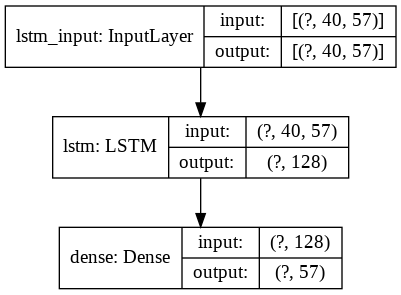

In [9]:
# build the model: a single LSTM
print('Build model...')
model = createModel()

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy') #, optimizer=optimizer)

plotFile = plotModel(model, "first_model")
IPython.display.Image(plotFile) 



# Resume training from existing weights ?

In [0]:
modelFile = os.path.join(MODEL_DIR, "lstm_text_gen-loss_1.2006.h5") # None

if modelFile is not None and os.path.exists(modelFile):
  print("Initializing with weights from ", modelFile)
  model.load_weights(modelFile)

In [0]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

ckpt_filepath=os.path.join(MODEL_DIR, "lstm_text_gen-loss_{loss:.4f}.h5")
checkpoint_callback = ModelCheckpoint(ckpt_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')



# Train

In [0]:
callbacks = [print_callback]
if modelDirExists:
  callbacks.append(checkpoint_callback)

model.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=callbacks)

Epoch 1/60
1559/1565 [============================>.] - ETA: 0s - loss: 2.5163
----- Generating text after Epoch: 0

----- Generating with seed (diversity=0.20): "aps favour the growth of another and str"
	
aps favour the growth of another and strenge the the the the the the the the the the hat in the the the the presting the the the the prenge the the prespinge the the the the the the and and and the prenate the the the and the the the serenting of the the the the the the the the the the the mand and the the the the the the the in the the the the the the the ingerent on the serend the the the herere the here the preante the and and the se

----- Generating with seed (diversity=0.50): "aps favour the growth of another and str"
	
aps favour the growth of another and stre buthing the wire fired the berevey of the mingtous able frealid of ef and the hate the perenens to the a the with the sereres fat the there the the
herere t eunt erelly the and the hathe in the wing hume thet of the the